In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Путь к изображениям
path1 = 'C:/Users/LEGION/Desktop/notebooks/весенний сем/нейронки/lab2_opencv/DSC02692.JPG'
path2 = 'C:/Users/LEGION/Desktop/notebooks/весенний сем/нейронки/lab2_opencv/DSC02694.JPG'

# Загрузка изображений
img1 = cv2.imread(path1)
img2 = cv2.imread(path2)

gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# Внутренние параметры камеры
K = np.array([[6.05304386e+03, 0.00000000e+00, 2.54106629e+03],
              [0.00000000e+00, 6.03790771e+03, 1.30293217e+03],
              [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

# Коэффициенты дисторсии
dist_coeffs = np.array([[-1.75617496e-01,  3.62500911e+00,  3.27014250e-03, 
                         3.28190397e-03, -2.11790265e+01]])


In [2]:
sift = cv2.SIFT_create()

kp1, des1 = sift.detectAndCompute(gray1, None)
kp2, des2 = sift.detectAndCompute(gray2, None)

bf = cv2.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)

# Фильтрация хороших совпадений
good = []
for m, n in matches:
    if m.distance < 0.80 * n.distance:
        good.append(m)

# Получение координат точек
pts1 = np.float32([kp1[m.queryIdx].pt for m in good])
pts2 = np.float32([kp2[m.trainIdx].pt for m in good])

print("Количество хороших совпадений:", len(good))


Количество хороших совпадений: 544


In [3]:
E, mask = cv2.findEssentialMat(pts1, pts2, K, method=cv2.RANSAC, prob=0.999, threshold=1.0)
_, R, T, mask = cv2.recoverPose(E, pts1, pts2, K)

print("Матрица поворота R:\n", R)
print("\nВектор смещения T:\n", T)

# Построение проекционных матриц
P1 = K @ np.hstack((np.eye(3), np.zeros((3, 1))))
P2 = K @ np.hstack((R, T))


Матрица поворота R:
 [[ 0.66820995 -0.06821106 -0.74083919]
 [ 0.08276397  0.99642257 -0.01709323]
 [ 0.73935484 -0.04989292  0.6714649 ]]

Вектор смещения T:
 [[0.84614687]
 [0.05317622]
 [0.53029026]]


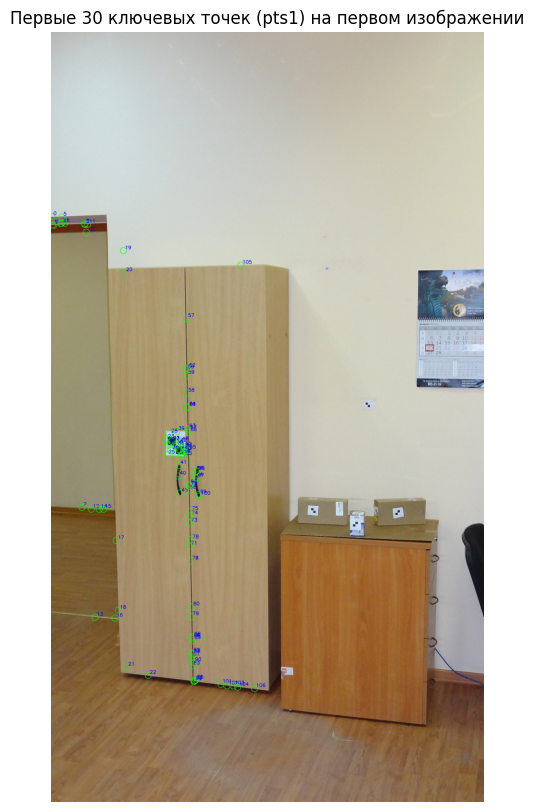

True

In [4]:
img_vis = img1.copy()

# Рисуем первые 30 ключевых точек
for i in range(107):
    x, y = map(int, pts1[i])
    cv2.circle(img_vis, (x, y), 20, (0, 255, 0), 2)
    cv2.putText(img_vis, str(i), (x + 10, y - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255, 0, 0), 2)

plt.figure(figsize=(12, 10))
plt.imshow(cv2.cvtColor(img_vis, cv2.COLOR_BGR2RGB))
plt.title("Первые 30 ключевых точек (pts1) на первом изображении")
plt.axis('off')
plt.show()
# Сохраняем изображение
cv2.imwrite("keypoints_marked.jpg", img_vis)


In [5]:
# Масштаб по точкам 105 (верх) и 106 (низ) двери
i1, i2 = 105, 106

pt1_top = pts1[i1]
pt1_bottom = pts1[i2]
pt2_top = pts2[i1]
pt2_bottom = pts2[i2]

top_3d = cv2.triangulatePoints(P1, P2, pt1_top.reshape(2, 1), pt2_top.reshape(2, 1))
bottom_3d = cv2.triangulatePoints(P1, P2, pt1_bottom.reshape(2, 1), pt2_bottom.reshape(2, 1))

top_3d /= top_3d[3]
bottom_3d /= bottom_3d[3]

# Виртуальное расстояние между точками
door_virtual = np.linalg.norm(top_3d[:3] - bottom_3d[:3])

# Реальная высота двери (из ТЗ)
real_door_mm = 2000.0

# Масштаб
scale_factor = real_door_mm / door_virtual

print(f"📐 Виртуальная высота двери: {door_virtual:.4f} ед.")
print(f"📏 Масштаб (мм на ед.): {scale_factor:.2f}")


📐 Виртуальная высота двери: 0.3471 ед.
📏 Масштаб (мм на ед.): 5761.67


In [6]:
# Используем выбранные точки на шкафу
i3, i4 = 105, 106

pt1_top = pts1[i3]
pt1_bottom = pts1[i4]
pt2_top = pts2[i3]
pt2_bottom = pts2[i4]

# Триангуляция 3D-точек
top_3d = cv2.triangulatePoints(P1, P2, pt1_top.reshape(2, 1), pt2_top.reshape(2, 1))
bottom_3d = cv2.triangulatePoints(P1, P2, pt1_bottom.reshape(2, 1), pt2_bottom.reshape(2, 1))

top_3d /= top_3d[3]
bottom_3d /= bottom_3d[3]

# Расстояние между точками в виртуальных единицах
height_virtual = np.linalg.norm(top_3d[:3] - bottom_3d[:3])

# Используем масштаб, рассчитанный по двери
height_real_mm = height_virtual * scale_factor

print(f"✅ Виртуальная высота шкафа: {height_virtual:.4f} ед.")
print(f"📏 Реальная высота шкафа: {height_real_mm:.2f} мм")


✅ Виртуальная высота шкафа: 0.3471 ед.
📏 Реальная высота шкафа: 2000.00 мм
